# Setup

*Assume that the survey data is exactly what we need
test using thresholds from the online data set 
-train using online data set and then test using the csv data set


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
random_seed = 1998
#np.random.seed(0)

# Importing Data

In [ ]:
data = pd.read_csv("/content/drive/Shared drives/Usable Passwords COMPS/Online Dataset Testing/DSL-StrongPasswordData.csv")
data = data[data.columns[:-3]] # remove return key from data set (if data set is in correct format)
individuals = data["subject"].unique() # NumPy: returns the sorted unique elements
# individuals = array of user ids ('unique' ids), s002 to s057
# array(['s002', 's003', 's004', 's005', 's007', 's008', 's010', 's011',
#        's012', 's013', 's015', 's016', 's017', 's018', 's019', 's020',
#        's021', 's022', 's024', 's025', 's026', 's027', 's028', 's029',
#        's030', 's031', 's032', 's033', 's034', 's035', 's036', 's037',
#        's038', 's039', 's040', 's041', 's042', 's043', 's044', 's046',
#        's047', 's048', 's049', 's050', 's051', 's052', 's053', 's054',
#        's055', 's056', 's057'], dtype=object)

columns_to_drop = [i for i in data.columns if "DD." in i] # remove down-down columns
columns_to_keep = data.columns.drop(columns_to_drop)
data = data[columns_to_keep]
individuals = data["subject"].unique()

# Plotting Digraph Distributions

plotting distributions


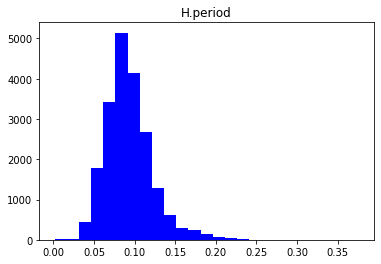

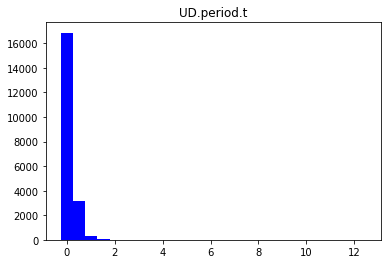

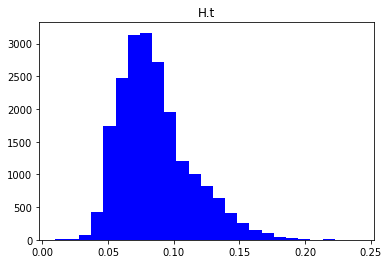

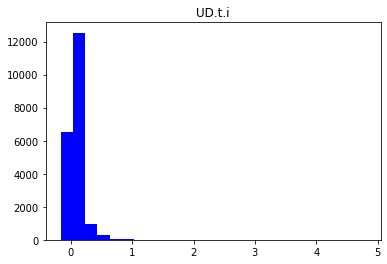

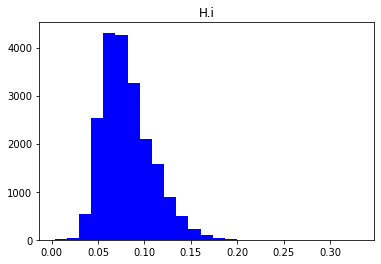

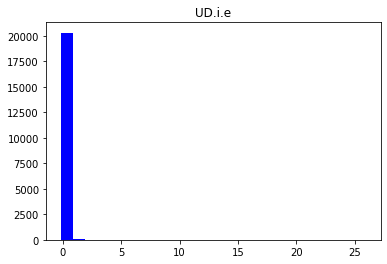







plotting log scaled distributions


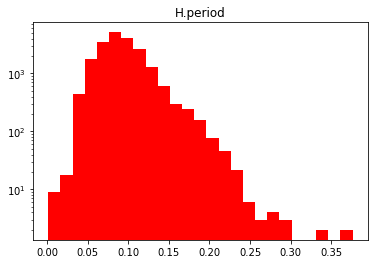

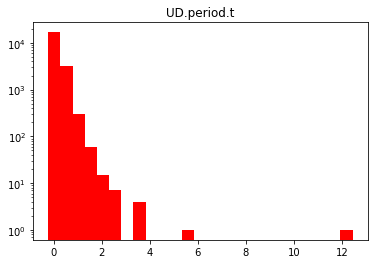

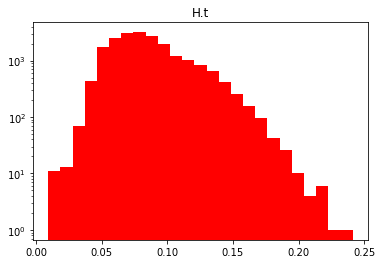

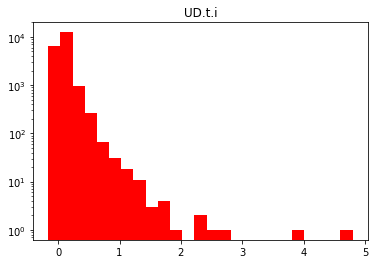

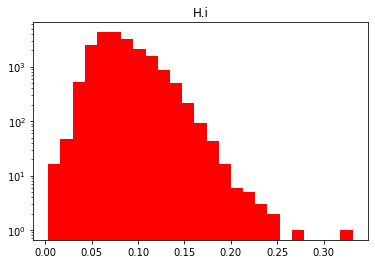

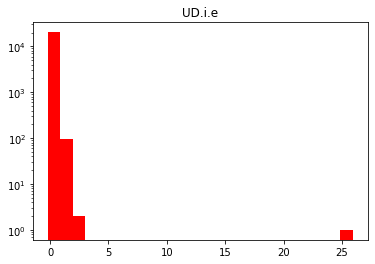

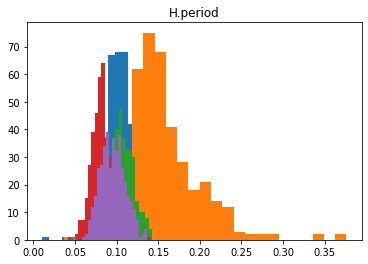

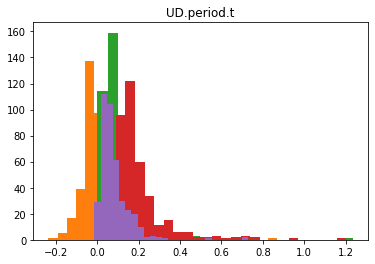

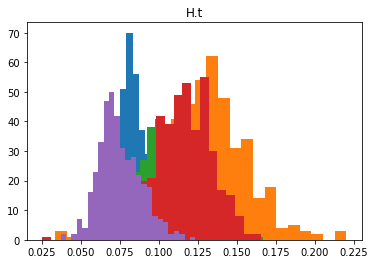

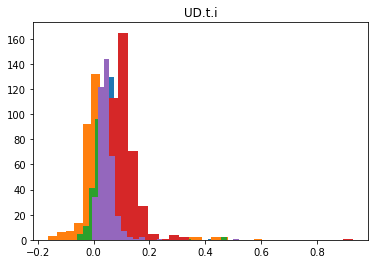

KeyboardInterrupt: ignored

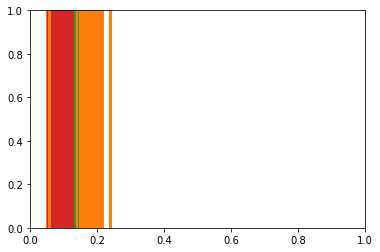

In [ ]:
print("plotting distributions") # individual column distributions (histograms)
for digraph in data.columns[3:][:6]:
  instances = data[digraph]
  plt.hist(instances, bins=25, color="blue")
  plt.title(digraph)
  plt.show()

print("\n" * 5)
print("plotting log scaled distributions")
for digraph in data.columns[3:][:6]:
  instances = data[digraph]
  plt.hist(instances, bins=25, log=True, color="red")
  plt.title(digraph)
  plt.show()

print("\n" * 5)

for keystroke in range(3,8):
  for user_index in range(5):
    user = individuals[user_index]
    digraph_diagnostics = data[data["subject"] == user]
    plt.hist(digraph_diagnostics[data.columns[keystroke]], bins=25)
  plt.title(data.columns[keystroke])
  plt.show()

# Defining Probability and Min-max functions

In [ ]:
def get_probability_trained_bound(df, user, session, repetitions = 10):
  '''
  Extract useful data, and compute the mean and variance for 'repetitions' amount of 
  trials.
  '''
  # right now, we are assuming it's a normal distribution
  usable_rows = (df["subject"] == user) & (df["sessionIndex"] == session) # filter 1 user, 1 session
  df = df[usable_rows] # usable = chosen user and session
  global random_seed 
  # return df.size (1100)
  df = df.sample(frac=1, random_state = random_seed) # pandas: return a random sample, where frac = fraction of axis items to return
  # return df.size (1100)??? <Q> why sample? -> randomizes rows
  df.reset_index(inplace=True, drop=True) # resets index 
  df = df.loc[:repetitions-1] # get only 'repetitions' amount of rows
  df = df[df.columns[3:]] # remove subject, sessionIndex, rep

  average_row = {}
  stdv = {}
  for i in df.columns:
    average_row[i] = df[i].mean()
    stdv[i] = df[i].std()
  df = df.append(average_row, ignore_index=True)
  df = df.append(stdv, ignore_index=True)

  probability_trained_bound = df.loc[repetitions:] # mean, stdev
  probability_trained_bound = probability_trained_bound.rename(index={repetitions:"avg", repetitions+1:"stdv"})
  return probability_trained_bound

In [ ]:
get_probability_trained_bound(data, user = "s002", session = 1, repetitions = 10)

In [ ]:
def get_random_samples(df, user, session, num_samples = 10):
  '''
  These are the extracted data we use to figure out the mean and stdev.
  *depends on seed and num_samples/ repetitions.
  '''
  usable_rows = (df["subject"] == user) & (df["sessionIndex"] == session)
  df = df[usable_rows]
  global random_seed 
  df = df.sample(frac=1, random_state = random_seed)
  df.reset_index(inplace=True, drop=True)
  df = df.loc[:num_samples-1]
  df = df[df.columns[3:]]
  return df

In [ ]:
get_random_samples(data, "s002", 1, 10)

,H.period,UD.period.t,H.t,UD.t.i,H.i,UD.i.e,H.e,UD.e.five,H.five,UD.five.Shift.r,H.Shift.r,UD.Shift.r.o,H.o,UD.o.a,H.a,UD.a.n,H.n,UD.n.l,H.l
0,0.0993,0.0403,0.0779,0.0995,0.0692,0.1109,0.0940,0.9496,0.0818,0.3790,0.1197,0.0607,0.0876,0.0109,0.1330,0.0542,0.0834,0.1594,0.0982
1,0.1161,0.0984,0.0755,0.0697,0.0900,0.0731,0.0800,0.8299,0.0713,0.5120,0.1204,0.1254,0.0842,0.0919,0.1388,0.0507,0.0766,0.2098,0.0821
2,0.1243,0.0598,0.0768,0.0800,0.0850,0.0689,0.0826,0.7732,0.0686,0.4632,0.1078,0.1911,0.0792,0.0774,0.1161,0.0201,0.0679,0.1987,0.1222
3,0.1016,0.0358,0.0861,0.0768,0.0774,0.0747,0.0747,0.6418,0.0932,0.4807,0.0919,0.1584,0.0246,0.2780,0.1396,0.0228,0.0779,0.1269,0.0903
4,0.0776,0.4219,0.0998,0.0570,0.0892,0.0919,0.0684,0.5863,0.0839,0.3450,0.1157,0.1568,0.0913,0.0481,0.1095,0.0898,0.0779,0.1385,0.0942
5,0.0903,0.0968,0.0805,0.1114,0.0842,0.0758,0.0615,0.8550,0.0887,0.6753,0.1399,0.2555,0.0961,0.3376,0.1283,0.0602,0.0734,0.2093,0.1188
6,0.0948,0.1031,0.0760,0.0652,0.0776,0.0676,0.0787,0.8033,0.0800,0.5793,0.1201,0.2399,0.0993,0.0906,0.1610,0.0106,0.0781,0.1462,0.1066
7,0.1172,0.0559,0.0737,0.0586,0.0855,0.0655,0.0708,1.0167,0.0948,0.4862,0.1299,0.1154,0.1003,0.0188,0.1325,0.0431,0.0934,0.1581,0.0805
8,0.1043,0.2102,0.0971,0.0826,0.0979,0.1098,0.0803,0.8019,0.0990,0.3988,0.1190,0.1613,0.0855,0.0724,0.1407,0.0813,0.0900,0.1750,0.1003
9,0.1272,0.0678,0.0824,0.0618,0.0776,0.0750,0.0908,0.5349,0.0805,0.4355,0.1127,0.1019,0.0655,0.2012,0.1526,0.0507,0.0869,0.6230,0.1119


# Testing

In [ ]:
def update_confusion_matrix(confusion_matrix, min_limit, max_limit, samples, true_user, acceptable_num_digraphs_out_of_bounds = 0):
  for i in samples.index:
    if (sum((samples.loc[i] - min_limit) < 0) > acceptable_num_digraphs_out_of_bounds) or (sum((max_limit - samples.loc[i]) < 0) > acceptable_num_digraphs_out_of_bounds):
      confusion_matrix[true_user+"R"] = confusion_matrix[true_user+"R"] + 1
    else:
      confusion_matrix[true_user+"A"] = confusion_matrix[true_user+"A"] + 1
  return confusion_matrix

In [ ]:
def test_probability_trained_bound(df, user, bounds_to_test, repetitions_train = 10, repetitions_test = 50, acceptable_num_digraphs_out_of_bounds = 0):
  confusion_matrix_progression = {"TA":[], "TR":[], "FA":[], "FR":[]}
  for bound in bounds_to_test:
    print(bound)
    confusion_matrix = {"TA":0, "TR":0, "FA":0, "FR":0}
    # np.random.seed(0) 
    training_session = 1 # np.random.randint(1, 9) aha
    avg_stdv = get_probability_trained_bound(df, user, training_session, repetitions_train)
    #       H.period  UD.period.t       H.t  ...       H.n    UD.n.l       H.l
    # avg   0.105270     0.119000  0.082580  ...  0.080550  0.214490  0.100510
    # stdv  0.015819     0.117596  0.009139  ...  0.007815  0.146463  0.014378

    # limit calculations
    max_limit = avg_stdv.loc["avg"] + bound * avg_stdv.loc["stdv"]
    min_limit = avg_stdv.loc["avg"] - bound * avg_stdv.loc["stdv"]

    # 1) TRUE: test 9 sessions data against mean/ stdev calculations
    # we are trying to identify a 'user' (testing for one user's sessions)
    for session in range(1, 9):
      if session == training_session:
        continue
      random_sample = get_random_samples(df, user, session, repetitions_test) # session...? (just get sample from 'data' to test against)
      confusion_matrix = update_confusion_matrix(confusion_matrix, min_limit, max_limit, random_sample, "T", acceptable_num_digraphs_out_of_bounds)

    # 2) FALSE: test all users data against mean/ stdev calculations
    # uniqueness of one user so test against OTHER users
    for test_user in df["subject"].unique():
      if test_user == user:
        continue
      for session in range(1, 9):
        random_sample = get_random_samples(df, test_user, session, repetitions_test)
        confusion_matrix = update_confusion_matrix(confusion_matrix, min_limit, max_limit, random_sample, "F", acceptable_num_digraphs_out_of_bounds)
    
    # update TA, TR, FA, FR counts
    for key in confusion_matrix_progression.keys():
      confusion_matrix_progression[key].append(confusion_matrix[key])

  return confusion_matrix_progression

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 10, 70, 186, 255, 290, 312, 325, 333, 338], 'TR': [350, 350, 340, 280, 164, 95, 60, 38, 25, 17, 12], 'FA': [0, 0, 2, 107, 1482, 6923, 10827, 13098, 14580, 15610, 16389], 'FR': [20000, 20000, 19998, 19893, 18518, 13077, 9173, 6902, 5420, 4390, 3611]}
total cm:  {}
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 3, 39, 118, 168, 205, 230, 251, 283, 302], 'TR': [350, 350, 347, 311, 232, 182, 145, 120, 99, 67, 48], 'FA': [0, 0, 0, 45, 460, 2039, 5164, 8567, 11391, 13436, 14689], 'FR': [20000, 20000, 20000, 19955, 19540, 17961, 14836, 11433, 8609, 6564, 5311]}
total cm:  {'TA': [0, 0, 10, 70, 186, 255, 290, 312, 325, 333, 338], 'TR': [350, 350, 340, 280, 164, 95, 60, 38, 25, 17, 12], 'FA': [0, 0, 2, 107, 1482, 6923, 10827, 13098, 14580, 15610, 16389], 'FR': [20000, 20000, 19998, 19893, 18518, 13077, 9173, 6902, 5420, 4390, 3611]}


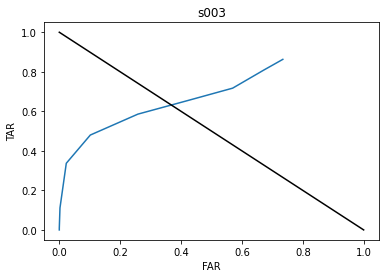

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 1, 31, 108, 198, 247, 275, 298, 314, 324], 'TR': [350, 350, 349, 319, 242, 152, 103, 75, 52, 36, 26], 'FA': [0, 0, 0, 52, 596, 2085, 3929, 5876, 7764, 9514, 10992], 'FR': [20000, 20000, 20000, 19948, 19404, 17915, 16071, 14124, 12236, 10486, 9008]}
total cm:  {'TA': [0, 0, 13, 109, 304, 423, 495, 542, 576, 616, 640], 'TR': [700, 700, 687, 591, 396, 277, 205, 158, 124, 84, 60], 'FA': [0, 0, 2, 152, 1942, 8962, 15991, 21665, 25971, 29046, 31078], 'FR': [40000, 40000, 39998, 39848, 38058, 31038, 24009, 18335, 14029, 10954, 8922]}


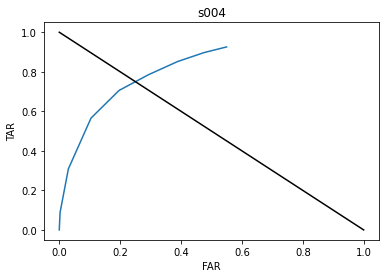

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 29, 176, 266, 294, 311, 320, 327, 329, 333], 'TR': [350, 350, 321, 174, 84, 56, 39, 30, 23, 21, 17], 'FA': [0, 0, 1, 35, 805, 3445, 6441, 8988, 11105, 12777, 14868], 'FR': [20000, 20000, 19999, 19965, 19195, 16555, 13559, 11012, 8895, 7223, 5132]}
total cm:  {'TA': [0, 0, 14, 140, 412, 621, 742, 817, 874, 930, 964], 'TR': [1050, 1050, 1036, 910, 638, 429, 308, 233, 176, 120, 86], 'FA': [0, 0, 2, 204, 2538, 11047, 19920, 27541, 33735, 38560, 42070], 'FR': [60000, 60000, 59998, 59796, 57462, 48953, 40080, 32459, 26265, 21440, 17930]}


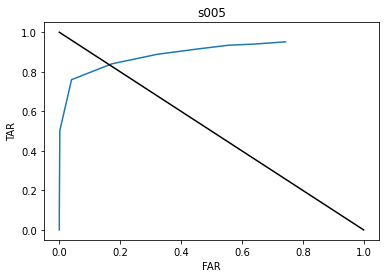

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 4, 26, 86, 197, 288, 331, 338, 341, 342], 'TR': [350, 350, 346, 324, 264, 153, 62, 19, 12, 9, 8], 'FA': [0, 0, 29, 923, 3555, 6890, 9769, 11940, 13474, 14528, 15307], 'FR': [20000, 20000, 19971, 19077, 16445, 13110, 10231, 8060, 6526, 5472, 4693]}
total cm:  {'TA': [0, 0, 43, 316, 678, 915, 1053, 1137, 1201, 1259, 1297], 'TR': [1400, 1400, 1357, 1084, 722, 485, 347, 263, 199, 141, 103], 'FA': [0, 0, 3, 239, 3343, 14492, 26361, 36529, 44840, 51337, 56938], 'FR': [80000, 80000, 79997, 79761, 76657, 65508, 53639, 43471, 35160, 28663, 23062]}


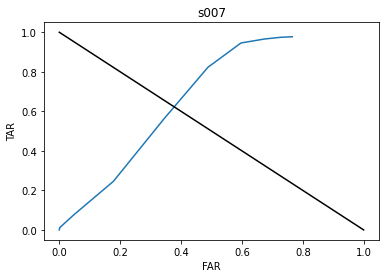

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 31, 183, 281, 318, 330, 337, 342, 346, 347], 'TR': [350, 350, 319, 167, 69, 32, 20, 13, 8, 4, 3], 'FA': [0, 0, 79, 1666, 5215, 9093, 12398, 14310, 15441, 16201, 16775], 'FR': [20000, 20000, 19921, 18334, 14785, 10907, 7602, 5690, 4559, 3799, 3225]}
total cm:  {'TA': [0, 0, 47, 342, 764, 1112, 1341, 1468, 1539, 1600, 1639], 'TR': [1750, 1750, 1703, 1408, 986, 638, 409, 282, 211, 150, 111], 'FA': [0, 0, 32, 1162, 6898, 21382, 36130, 48469, 58314, 65865, 72245], 'FR': [100000, 100000, 99968, 98838, 93102, 78618, 63870, 51531, 41686, 34135, 27755]}


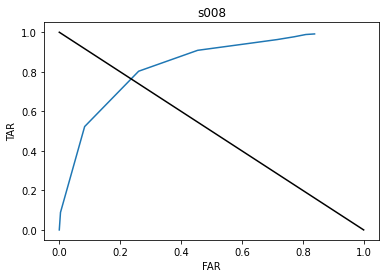

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 8, 79, 185, 256, 289, 301, 314, 325, 332], 'TR': [350, 350, 342, 271, 165, 94, 61, 49, 36, 25, 18], 'FA': [0, 0, 0, 24, 255, 976, 2262, 3787, 5092, 6319, 7457], 'FR': [20000, 20000, 20000, 19976, 19745, 19024, 17738, 16213, 14908, 13681, 12543]}
total cm:  {'TA': [0, 0, 78, 525, 1045, 1430, 1671, 1805, 1881, 1946, 1986], 'TR': [2100, 2100, 2022, 1575, 1055, 670, 429, 295, 219, 154, 114], 'FA': [0, 0, 111, 2828, 12113, 30475, 48528, 62779, 73755, 82066, 89020], 'FR': [120000, 120000, 119889, 117172, 107887, 89525, 71472, 57221, 46245, 37934, 30980]}


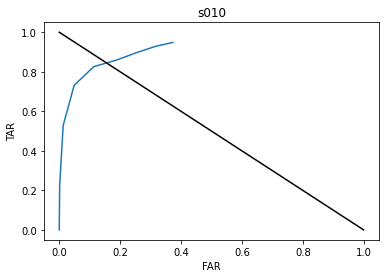

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 14, 88, 216, 295, 330, 339, 342, 343, 344], 'TR': [350, 350, 336, 262, 134, 55, 20, 11, 8, 7, 6], 'FA': [0, 0, 80, 1044, 3678, 6977, 10108, 12864, 14870, 15910, 16492], 'FR': [20000, 20000, 19920, 18956, 16322, 13023, 9892, 7136, 5130, 4090, 3508]}
total cm:  {'TA': [0, 0, 86, 604, 1230, 1686, 1960, 2106, 2195, 2271, 2318], 'TR': [2450, 2450, 2364, 1846, 1220, 764, 490, 344, 255, 179, 132], 'FA': [0, 0, 111, 2852, 12368, 31451, 50790, 66566, 78847, 88385, 96477], 'FR': [140000, 140000, 139889, 137148, 127632, 108549, 89210, 73434, 61153, 51615, 43523]}


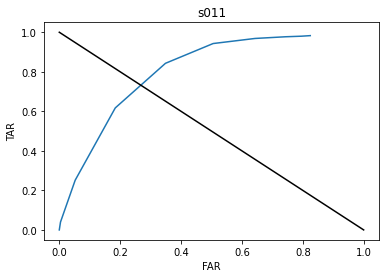

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 4, 69, 197, 265, 298, 314, 334, 341, 341], 'TR': [350, 350, 346, 281, 153, 85, 52, 36, 16, 9, 9], 'FA': [0, 0, 2, 190, 1594, 4562, 7970, 11129, 13620, 15103, 15879], 'FR': [20000, 20000, 19998, 19810, 18406, 15438, 12030, 8871, 6380, 4897, 4121]}
total cm:  {'TA': [0, 0, 100, 692, 1446, 1981, 2290, 2445, 2537, 2614, 2662], 'TR': [2800, 2800, 2700, 2108, 1354, 819, 510, 355, 263, 186, 138], 'FA': [0, 0, 191, 3896, 16046, 38428, 60898, 79430, 93717, 104295, 112969], 'FR': [160000, 160000, 159809, 156104, 143954, 121572, 99102, 80570, 66283, 55705, 47031]}


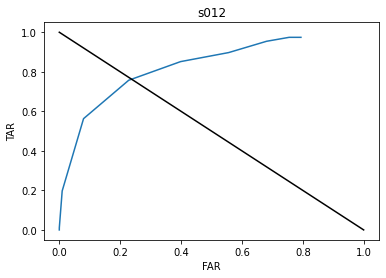

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 24, 182, 277, 307, 322, 330, 333, 335, 336], 'TR': [350, 350, 326, 168, 73, 43, 28, 20, 17, 15, 14], 'FA': [0, 0, 12, 331, 1293, 2871, 4633, 6282, 7706, 9034, 10355], 'FR': [20000, 20000, 19988, 19669, 18707, 17129, 15367, 13718, 12294, 10966, 9645]}
total cm:  {'TA': [0, 0, 104, 761, 1643, 2246, 2588, 2759, 2871, 2955, 3003], 'TR': [3150, 3150, 3046, 2389, 1507, 904, 562, 391, 279, 195, 147], 'FA': [0, 0, 193, 4086, 17640, 42990, 68868, 90559, 107337, 119398, 128848], 'FR': [180000, 180000, 179807, 175914, 162360, 137010, 111132, 89441, 72663, 60602, 51152]}


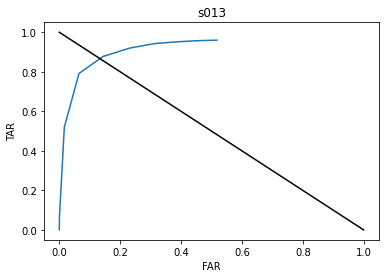

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 61, 208, 274, 295, 315, 323, 328, 333, 336], 'TR': [350, 350, 289, 142, 76, 55, 35, 27, 22, 17, 14], 'FA': [0, 0, 353, 2614, 5957, 9386, 11899, 13743, 15232, 16295, 17092], 'FR': [20000, 20000, 19647, 17386, 14043, 10614, 8101, 6257, 4768, 3705, 2908]}
total cm:  {'TA': [0, 0, 128, 943, 1920, 2553, 2910, 3089, 3204, 3290, 3339], 'TR': [3500, 3500, 3372, 2557, 1580, 947, 590, 411, 296, 210, 161], 'FA': [0, 0, 205, 4417, 18933, 45861, 73501, 96841, 115043, 128432, 139203], 'FR': [200000, 200000, 199795, 195583, 181067, 154139, 126499, 103159, 84957, 71568, 60797]}


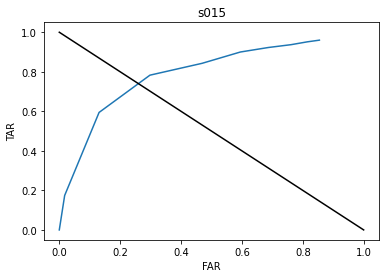

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 31, 175, 241, 285, 310, 323, 329, 333, 339], 'TR': [350, 350, 319, 175, 109, 65, 40, 27, 21, 17, 11], 'FA': [0, 0, 0, 115, 1393, 8756, 13634, 15328, 16569, 17585, 18348], 'FR': [20000, 20000, 20000, 19885, 18607, 11244, 6366, 4672, 3431, 2415, 1652]}
total cm:  {'TA': [0, 0, 189, 1151, 2194, 2848, 3225, 3412, 3532, 3623, 3675], 'TR': [3850, 3850, 3661, 2699, 1656, 1002, 625, 438, 318, 227, 175], 'FA': [0, 0, 558, 7031, 24890, 55247, 85400, 110584, 130275, 144727, 156295], 'FR': [220000, 220000, 219442, 212969, 195110, 164753, 134600, 109416, 89725, 75273, 63705]}


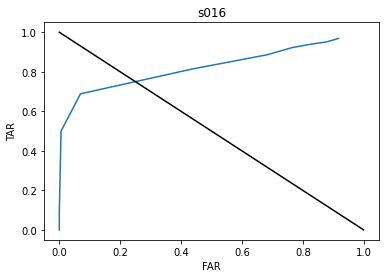

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 15, 116, 206, 271, 302, 319, 327, 330, 331], 'TR': [350, 350, 335, 234, 144, 79, 48, 31, 23, 20, 19], 'FA': [0, 0, 0, 13, 118, 413, 827, 1311, 2032, 2912, 4161], 'FR': [20000, 20000, 20000, 19987, 19882, 19587, 19173, 18689, 17968, 17088, 15839]}
total cm:  {'TA': [0, 0, 220, 1326, 2435, 3133, 3535, 3735, 3861, 3956, 4014], 'TR': [4200, 4200, 3980, 2874, 1765, 1067, 665, 465, 339, 244, 186], 'FA': [0, 0, 558, 7146, 26283, 64003, 99034, 125912, 146844, 162312, 174643], 'FR': [240000, 240000, 239442, 232854, 213717, 175997, 140966, 114088, 93156, 77688, 65357]}


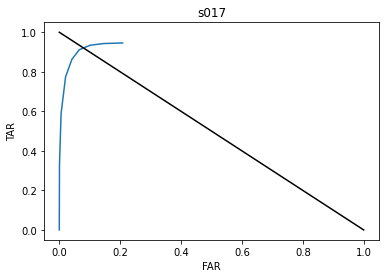

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 42, 156, 227, 265, 282, 289, 299, 304, 309], 'TR': [350, 350, 308, 194, 123, 85, 68, 61, 51, 46, 41], 'FA': [0, 0, 183, 3165, 8023, 11483, 13155, 14353, 15328, 16193, 16863], 'FR': [20000, 20000, 19817, 16835, 11977, 8517, 6845, 5647, 4672, 3807, 3137]}
total cm:  {'TA': [0, 0, 235, 1442, 2641, 3404, 3837, 4054, 4188, 4286, 4345], 'TR': [4550, 4550, 4315, 3108, 1909, 1146, 713, 496, 362, 264, 205], 'FA': [0, 0, 558, 7159, 26401, 64416, 99861, 127223, 148876, 165224, 178804], 'FR': [260000, 260000, 259442, 252841, 233599, 195584, 160139, 132777, 111124, 94776, 81196]}


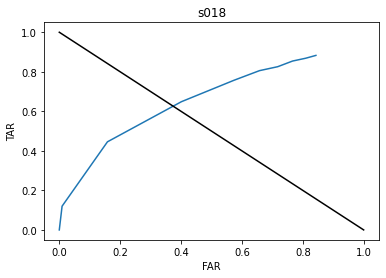

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 10, 94, 202, 261, 292, 302, 317, 320, 323], 'TR': [350, 350, 340, 256, 148, 89, 58, 48, 33, 30, 27], 'FA': [0, 0, 0, 0, 20, 417, 1918, 3929, 5835, 7431, 8701], 'FR': [20000, 20000, 20000, 20000, 19980, 19583, 18082, 16071, 14165, 12569, 11299]}
total cm:  {'TA': [0, 0, 277, 1598, 2868, 3669, 4119, 4343, 4487, 4590, 4654], 'TR': [4900, 4900, 4623, 3302, 2032, 1231, 781, 557, 413, 310, 246], 'FA': [0, 0, 741, 10324, 34424, 75899, 113016, 141576, 164204, 181417, 195667], 'FR': [280000, 280000, 279259, 269676, 245576, 204101, 166984, 138424, 115796, 98583, 84333]}


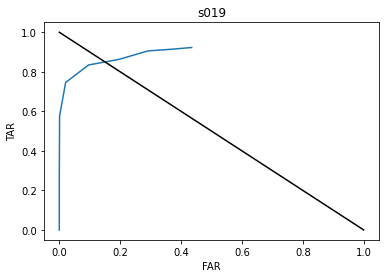

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 10, 43, 103, 157, 186, 205, 222, 231, 244], 'TR': [350, 350, 340, 307, 247, 193, 164, 145, 128, 119, 106], 'FA': [0, 0, 1, 56, 392, 1345, 2758, 4638, 6716, 8970, 10800], 'FR': [20000, 20000, 19999, 19944, 19608, 18655, 17242, 15362, 13284, 11030, 9200]}
total cm:  {'TA': [0, 0, 287, 1692, 3070, 3930, 4411, 4645, 4804, 4910, 4977], 'TR': [5250, 5250, 4963, 3558, 2180, 1320, 839, 605, 446, 340, 273], 'FA': [0, 0, 741, 10324, 34444, 76316, 114934, 145505, 170039, 188848, 204368], 'FR': [300000, 300000, 299259, 289676, 265556, 223684, 185066, 154495, 129961, 111152, 95632]}


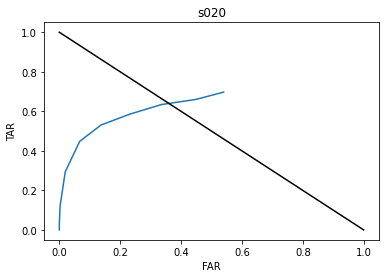

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 0, 1, 8, 22, 54, 102, 160, 203, 253], 'TR': [350, 350, 350, 349, 342, 328, 296, 248, 190, 147, 97], 'FA': [0, 0, 0, 0, 11, 150, 625, 1604, 3210, 5567, 8544], 'FR': [20000, 20000, 20000, 20000, 19989, 19850, 19375, 18396, 16790, 14433, 11456]}
total cm:  {'TA': [0, 0, 297, 1735, 3173, 4087, 4597, 4850, 5026, 5141, 5221], 'TR': [5600, 5600, 5303, 3865, 2427, 1513, 1003, 750, 574, 459, 379], 'FA': [0, 0, 742, 10380, 34836, 77661, 117692, 150143, 176755, 197818, 215168], 'FR': [320000, 320000, 319258, 309620, 285164, 242339, 202308, 169857, 143245, 122182, 104832]}


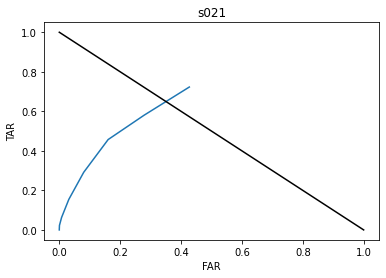

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 3, 10, 36, 67, 98, 130, 187, 286, 337], 'TR': [350, 350, 347, 340, 314, 283, 252, 220, 163, 64, 13], 'FA': [0, 0, 0, 0, 7, 46, 224, 697, 1344, 2334, 4262], 'FR': [20000, 20000, 20000, 20000, 19993, 19954, 19776, 19303, 18656, 17666, 15738]}
total cm:  {'TA': [0, 0, 297, 1736, 3181, 4109, 4651, 4952, 5186, 5344, 5474], 'TR': [5950, 5950, 5653, 4214, 2769, 1841, 1299, 998, 764, 606, 476], 'FA': [0, 0, 742, 10380, 34847, 77811, 118317, 151747, 179965, 203385, 223712], 'FR': [340000, 340000, 339258, 329620, 305153, 262189, 221683, 188253, 160035, 136615, 116288]}


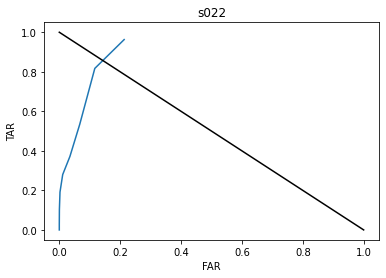

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 1, 49, 194, 247, 269, 282, 293, 304, 309, 313], 'TR': [350, 349, 301, 156, 103, 81, 68, 57, 46, 41, 37], 'FA': [0, 0, 0, 216, 648, 1156, 2036, 3183, 4574, 6164, 7673], 'FR': [20000, 20000, 20000, 19784, 19352, 18844, 17964, 16817, 15426, 13836, 12327]}
total cm:  {'TA': [0, 0, 300, 1746, 3217, 4176, 4749, 5082, 5373, 5630, 5811], 'TR': [6300, 6300, 6000, 4554, 3083, 2124, 1551, 1218, 927, 670, 489], 'FA': [0, 0, 742, 10380, 34854, 77857, 118541, 152444, 181309, 205719, 227974], 'FR': [360000, 360000, 359258, 349620, 325146, 282143, 241459, 207556, 178691, 154281, 132026]}


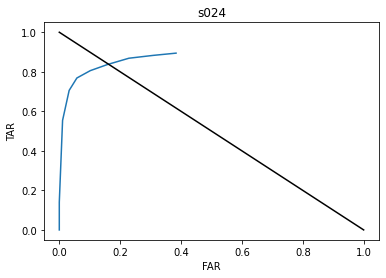

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 1, 37, 130, 201, 256, 289, 307, 321, 328, 334], 'TR': [350, 349, 313, 220, 149, 94, 61, 43, 29, 22, 16], 'FA': [0, 0, 0, 100, 708, 1850, 3244, 4899, 6587, 8397, 10092], 'FR': [20000, 20000, 20000, 19900, 19292, 18150, 16756, 15101, 13413, 11603, 9908]}
total cm:  {'TA': [0, 1, 349, 1940, 3464, 4445, 5031, 5375, 5677, 5939, 6124], 'TR': [6650, 6649, 6301, 4710, 3186, 2205, 1619, 1275, 973, 711, 526], 'FA': [0, 0, 742, 10596, 35502, 79013, 120577, 155627, 185883, 211883, 235647], 'FR': [380000, 380000, 379258, 369404, 344498, 300987, 259423, 224373, 194117, 168117, 144353]}


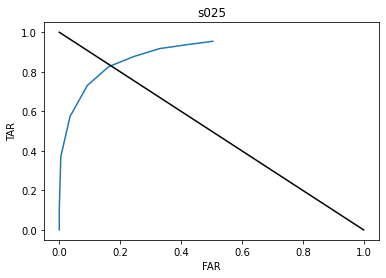

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 1, 22, 64, 100, 141, 178, 198, 212, 235], 'TR': [350, 350, 349, 328, 286, 250, 209, 172, 152, 138, 115], 'FA': [0, 0, 0, 6, 88, 543, 1519, 2832, 4355, 5809, 7083], 'FR': [20000, 20000, 20000, 19994, 19912, 19457, 18481, 17168, 15645, 14191, 12917]}
total cm:  {'TA': [0, 2, 386, 2070, 3665, 4701, 5320, 5682, 5998, 6267, 6458], 'TR': [7000, 6998, 6614, 4930, 3335, 2299, 1680, 1318, 1002, 733, 542], 'FA': [0, 0, 742, 10696, 36210, 80863, 123821, 160526, 192470, 220280, 245739], 'FR': [400000, 400000, 399258, 389304, 363790, 319137, 276179, 239474, 207530, 179720, 154261]}


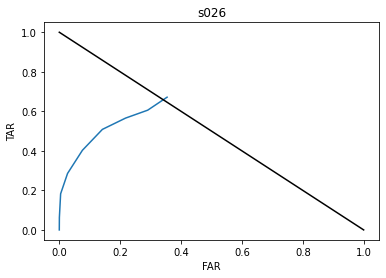

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 5, 41, 126, 206, 265, 301, 316, 324, 328], 'TR': [350, 350, 345, 309, 224, 144, 85, 49, 34, 26, 22], 'FA': [0, 0, 0, 2, 50, 560, 2385, 4857, 7304, 9495, 11293], 'FR': [20000, 20000, 20000, 19998, 19950, 19440, 17615, 15143, 12696, 10505, 8707]}
total cm:  {'TA': [0, 2, 387, 2092, 3729, 4801, 5461, 5860, 6196, 6479, 6693], 'TR': [7350, 7348, 6963, 5258, 3621, 2549, 1889, 1490, 1154, 871, 657], 'FA': [0, 0, 742, 10702, 36298, 81406, 125340, 163358, 196825, 226089, 252822], 'FR': [420000, 420000, 419258, 409298, 383702, 338594, 294660, 256642, 223175, 193911, 167178]}


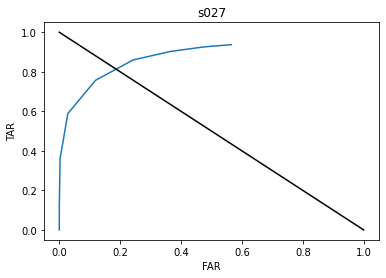

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 17, 80, 175, 227, 258, 279, 285, 290, 295], 'TR': [350, 350, 333, 270, 175, 123, 92, 71, 65, 60, 55], 'FA': [0, 0, 0, 7, 54, 365, 756, 1297, 2010, 2870, 3834], 'FR': [20000, 20000, 20000, 19993, 19946, 19635, 19244, 18703, 17990, 17130, 16166]}
total cm:  {'TA': [0, 2, 392, 2133, 3855, 5007, 5726, 6161, 6512, 6803, 7021], 'TR': [7700, 7698, 7308, 5567, 3845, 2693, 1974, 1539, 1188, 897, 679], 'FA': [0, 0, 742, 10704, 36348, 81966, 127725, 168215, 204129, 235584, 264115], 'FR': [440000, 440000, 439258, 429296, 403652, 358034, 312275, 271785, 235871, 204416, 175885]}


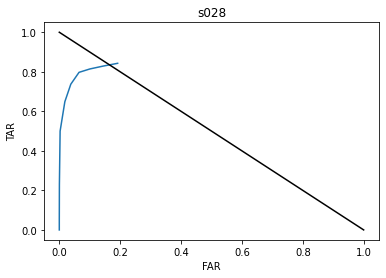

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 16, 90, 163, 235, 270, 297, 312, 315, 319], 'TR': [350, 350, 334, 260, 187, 115, 80, 53, 38, 35, 31], 'FA': [0, 0, 0, 32, 212, 623, 1308, 2358, 3679, 5204, 6831], 'FR': [20000, 20000, 20000, 19968, 19788, 19377, 18692, 17642, 16321, 14796, 13169]}
total cm:  {'TA': [0, 2, 409, 2213, 4030, 5234, 5984, 6440, 6797, 7093, 7316], 'TR': [8050, 8048, 7641, 5837, 4020, 2816, 2066, 1610, 1253, 957, 734], 'FA': [0, 0, 742, 10711, 36402, 82331, 128481, 169512, 206139, 238454, 267949], 'FR': [460000, 460000, 459258, 449289, 423598, 377669, 331519, 290488, 253861, 221546, 192051]}


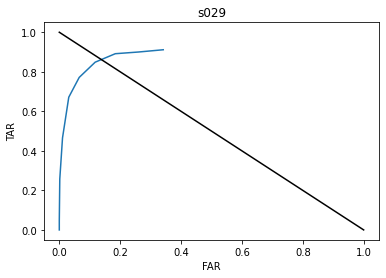

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 10, 61, 93, 141, 181, 225, 251, 270, 284], 'TR': [350, 350, 340, 289, 257, 209, 169, 125, 99, 80, 66], 'FA': [0, 0, 6, 906, 3983, 7307, 10207, 12451, 14023, 15356, 16342], 'FR': [20000, 20000, 19994, 19094, 16017, 12693, 9793, 7549, 5977, 4644, 3658]}
total cm:  {'TA': [0, 2, 425, 2303, 4193, 5469, 6254, 6737, 7109, 7408, 7635], 'TR': [8400, 8398, 7975, 6097, 4207, 2931, 2146, 1663, 1291, 992, 765], 'FA': [0, 0, 742, 10743, 36614, 82954, 129789, 171870, 209818, 243658, 274780], 'FR': [480000, 480000, 479258, 469257, 443386, 397046, 350211, 308130, 270182, 236342, 205220]}


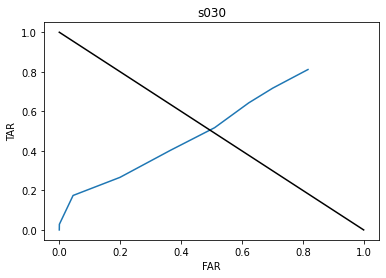

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 1, 6, 20, 50, 103, 162, 215, 266, 294], 'TR': [350, 350, 349, 344, 330, 300, 247, 188, 135, 84, 56], 'FA': [0, 0, 91, 1160, 3208, 5182, 7068, 8947, 10723, 12351, 13728], 'FR': [20000, 20000, 19909, 18840, 16792, 14818, 12932, 11053, 9277, 7649, 6272]}
total cm:  {'TA': [0, 2, 435, 2364, 4286, 5610, 6435, 6962, 7360, 7678, 7919], 'TR': [8750, 8748, 8315, 6386, 4464, 3140, 2315, 1788, 1390, 1072, 831], 'FA': [0, 0, 748, 11649, 40597, 90261, 139996, 184321, 223841, 259014, 291122], 'FR': [500000, 500000, 499252, 488351, 459403, 409739, 360004, 315679, 276159, 240986, 208878]}


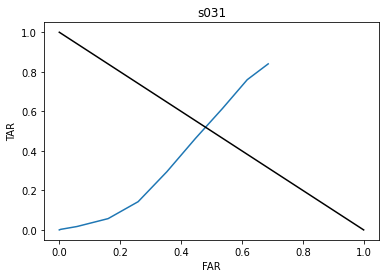

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 10, 42, 87, 123, 161, 184, 211, 239, 260], 'TR': [350, 350, 340, 308, 263, 227, 189, 166, 139, 111, 90], 'FA': [0, 0, 40, 833, 2337, 4117, 5887, 7488, 8913, 10242, 11432], 'FR': [20000, 20000, 19960, 19167, 17663, 15883, 14113, 12512, 11087, 9758, 8568]}
total cm:  {'TA': [0, 2, 436, 2370, 4306, 5660, 6538, 7124, 7575, 7944, 8213], 'TR': [9100, 9098, 8664, 6730, 4794, 3440, 2562, 1976, 1525, 1156, 887], 'FA': [0, 0, 839, 12809, 43805, 95443, 147064, 193268, 234564, 271365, 304850], 'FR': [520000, 520000, 519161, 507191, 476195, 424557, 372936, 326732, 285436, 248635, 215150]}


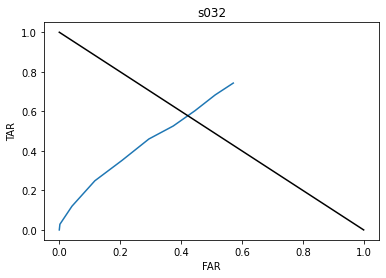

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 42, 172, 228, 256, 274, 284, 296, 310, 315], 'TR': [350, 350, 308, 178, 122, 94, 76, 66, 54, 40, 35], 'FA': [0, 0, 0, 90, 984, 3329, 6671, 11294, 14787, 16654, 17256], 'FR': [20000, 20000, 20000, 19910, 19016, 16671, 13329, 8706, 5213, 3346, 2744]}
total cm:  {'TA': [0, 2, 446, 2412, 4393, 5783, 6699, 7308, 7786, 8183, 8473], 'TR': [9450, 9448, 9004, 7038, 5057, 3667, 2751, 2142, 1664, 1267, 977], 'FA': [0, 0, 879, 13642, 46142, 99560, 152951, 200756, 243477, 281607, 316282], 'FR': [540000, 540000, 539121, 526358, 493858, 440440, 387049, 339244, 296523, 258393, 223718]}


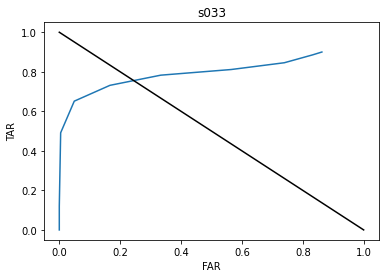

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 13, 44, 178, 271, 295, 317, 323, 326, 330], 'TR': [350, 350, 337, 306, 172, 79, 55, 33, 27, 24, 20], 'FA': [0, 0, 81, 1015, 5387, 9081, 11559, 13289, 14722, 15838, 16630], 'FR': [20000, 20000, 19919, 18985, 14613, 10919, 8441, 6711, 5278, 4162, 3370]}
total cm:  {'TA': [0, 2, 488, 2584, 4621, 6039, 6973, 7592, 8082, 8493, 8788], 'TR': [9800, 9798, 9312, 7216, 5179, 3761, 2827, 2208, 1718, 1307, 1012], 'FA': [0, 0, 879, 13732, 47126, 102889, 159622, 212050, 258264, 298261, 333538], 'FR': [560000, 560000, 559121, 546268, 512874, 457111, 400378, 347950, 301736, 261739, 226462]}


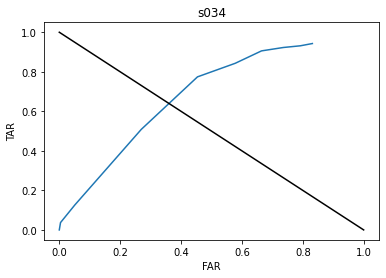

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 6, 46, 92, 147, 191, 233, 263, 289, 303], 'TR': [350, 350, 344, 304, 258, 203, 159, 117, 87, 61, 47], 'FA': [0, 0, 0, 4, 37, 145, 403, 1018, 2008, 3335, 5088], 'FR': [20000, 20000, 20000, 19996, 19963, 19855, 19597, 18982, 17992, 16665, 14912]}
total cm:  {'TA': [0, 2, 501, 2628, 4799, 6310, 7268, 7909, 8405, 8819, 9118], 'TR': [10150, 10148, 9649, 7522, 5351, 3840, 2882, 2241, 1745, 1331, 1032], 'FA': [0, 0, 960, 14747, 52513, 111970, 171181, 225339, 272986, 314099, 350168], 'FR': [580000, 580000, 579040, 565253, 527487, 468030, 408819, 354661, 307014, 265901, 229832]}


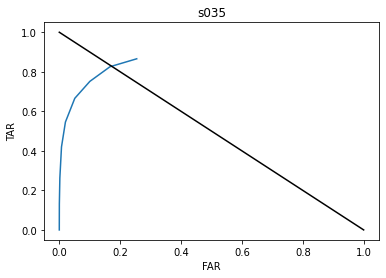

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 70, 226, 306, 330, 343, 345, 347, 349, 350], 'TR': [350, 350, 280, 124, 44, 20, 7, 5, 3, 1, 0], 'FA': [0, 0, 0, 1, 38, 246, 610, 1048, 1447, 1888, 2394], 'FR': [20000, 20000, 20000, 19999, 19962, 19754, 19390, 18952, 18553, 18112, 17606]}
total cm:  {'TA': [0, 2, 507, 2674, 4891, 6457, 7459, 8142, 8668, 9108, 9421], 'TR': [10500, 10498, 9993, 7826, 5609, 4043, 3041, 2358, 1832, 1392, 1079], 'FA': [0, 0, 960, 14751, 52550, 112115, 171584, 226357, 274994, 317434, 355256], 'FR': [600000, 600000, 599040, 585249, 547450, 487885, 428416, 373643, 325006, 282566, 244744]}


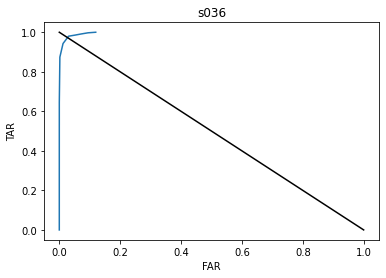

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 4, 65, 140, 201, 259, 301, 317, 325, 327], 'TR': [350, 350, 346, 285, 210, 149, 91, 49, 33, 25, 23], 'FA': [0, 0, 6, 127, 625, 1861, 4143, 6894, 9528, 11792, 13674], 'FR': [20000, 20000, 19994, 19873, 19375, 18139, 15857, 13106, 10472, 8208, 6326]}
total cm:  {'TA': [0, 2, 577, 2900, 5197, 6787, 7802, 8487, 9015, 9457, 9771], 'TR': [10850, 10848, 10273, 7950, 5653, 4063, 3048, 2363, 1835, 1393, 1079], 'FA': [0, 0, 960, 14752, 52588, 112361, 172194, 227405, 276441, 319322, 357650], 'FR': [620000, 620000, 619040, 605248, 567412, 507639, 447806, 392595, 343559, 300678, 262350]}


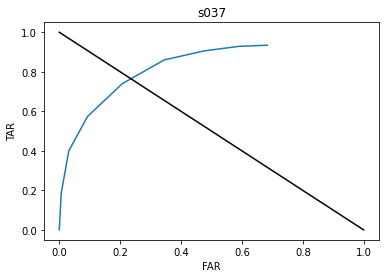

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 1, 80, 146, 206, 272, 310, 321, 333, 338, 340], 'TR': [350, 349, 270, 204, 144, 78, 40, 29, 17, 12, 10], 'FA': [0, 0, 486, 3216, 6611, 9637, 12145, 14163, 15582, 16680, 17465], 'FR': [20000, 20000, 19514, 16784, 13389, 10363, 7855, 5837, 4418, 3320, 2535]}
total cm:  {'TA': [0, 2, 581, 2965, 5337, 6988, 8061, 8788, 9332, 9782, 10098], 'TR': [11200, 11198, 10619, 8235, 5863, 4212, 3139, 2412, 1868, 1418, 1102], 'FA': [0, 0, 966, 14879, 53213, 114222, 176337, 234299, 285969, 331114, 371324], 'FR': [640000, 640000, 639034, 625121, 586787, 525778, 463663, 405701, 354031, 308886, 268676]}


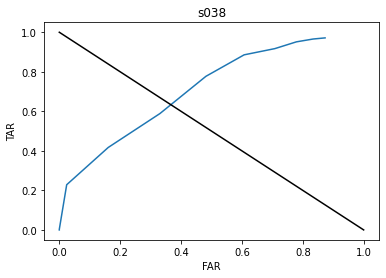

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 1, 56, 170, 246, 278, 293, 301, 307, 312, 314], 'TR': [350, 349, 294, 180, 104, 72, 57, 49, 43, 38, 36], 'FA': [0, 0, 0, 35, 524, 1974, 4107, 6351, 7980, 9276, 10334], 'FR': [20000, 20000, 20000, 19965, 19476, 18026, 15893, 13649, 12020, 10724, 9666]}
total cm:  {'TA': [0, 3, 661, 3111, 5543, 7260, 8371, 9109, 9665, 10120, 10438], 'TR': [11550, 11547, 10889, 8439, 6007, 4290, 3179, 2441, 1885, 1430, 1112], 'FA': [0, 0, 1452, 18095, 59824, 123859, 188482, 248462, 301551, 347794, 388789], 'FR': [660000, 660000, 658548, 641905, 600176, 536141, 471518, 411538, 358449, 312206, 271211]}


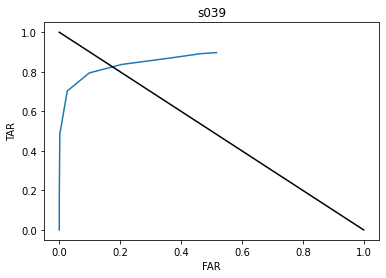

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 8, 61, 155, 228, 277, 301, 320, 328, 332], 'TR': [350, 350, 342, 289, 195, 122, 73, 49, 30, 22, 18], 'FA': [0, 0, 0, 182, 2597, 8013, 11864, 13955, 15333, 16362, 17196], 'FR': [20000, 20000, 20000, 19818, 17403, 11987, 8136, 6045, 4667, 3638, 2804]}
total cm:  {'TA': [0, 4, 717, 3281, 5789, 7538, 8664, 9410, 9972, 10432, 10752], 'TR': [11900, 11896, 11183, 8619, 6111, 4362, 3236, 2490, 1928, 1468, 1148], 'FA': [0, 0, 1452, 18130, 60348, 125833, 192589, 254813, 309531, 357070, 399123], 'FR': [680000, 680000, 678548, 661870, 619652, 554167, 487411, 425187, 370469, 322930, 280877]}


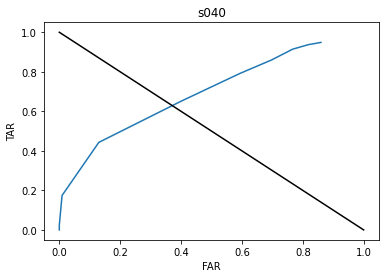

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 0, 2, 9, 38, 59, 101, 132, 175, 202], 'TR': [350, 350, 350, 348, 341, 312, 291, 249, 218, 175, 148], 'FA': [0, 0, 1, 69, 460, 2227, 5679, 8941, 11983, 13451, 14363], 'FR': [20000, 20000, 19999, 19931, 19540, 17773, 14321, 11059, 8017, 6549, 5637]}
total cm:  {'TA': [0, 4, 725, 3342, 5944, 7766, 8941, 9711, 10292, 10760, 11084], 'TR': [12250, 12246, 11525, 8908, 6306, 4484, 3309, 2539, 1958, 1490, 1166], 'FA': [0, 0, 1452, 18312, 62945, 133846, 204453, 268768, 324864, 373432, 416319], 'FR': [700000, 700000, 698548, 681688, 637055, 566154, 495547, 431232, 375136, 326568, 283681]}


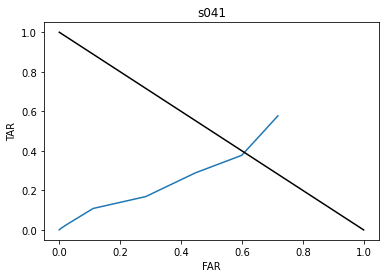

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 3, 42, 138, 228, 285, 314, 324, 324, 326], 'TR': [350, 350, 347, 308, 212, 122, 65, 36, 26, 26, 24], 'FA': [0, 0, 0, 0, 63, 378, 1163, 2372, 3893, 5710, 7470], 'FR': [20000, 20000, 20000, 20000, 19937, 19622, 18837, 17628, 16107, 14290, 12530]}
total cm:  {'TA': [0, 4, 725, 3344, 5953, 7804, 9000, 9812, 10424, 10935, 11286], 'TR': [12600, 12596, 11875, 9256, 6647, 4796, 3600, 2788, 2176, 1665, 1314], 'FA': [0, 0, 1453, 18381, 63405, 136073, 210132, 277709, 336847, 386883, 430682], 'FR': [720000, 720000, 718547, 701619, 656595, 583927, 509868, 442291, 383153, 333117, 289318]}


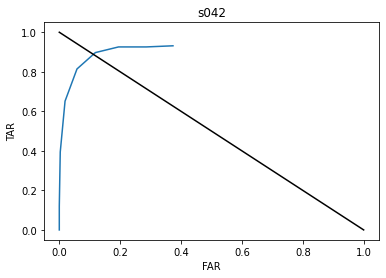

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 3, 29, 81, 162, 218, 263, 283, 302, 314], 'TR': [350, 350, 347, 321, 269, 188, 132, 87, 67, 48, 36], 'FA': [0, 0, 0, 1, 126, 833, 1538, 2166, 2898, 3720, 4550], 'FR': [20000, 20000, 20000, 19999, 19874, 19167, 18462, 17834, 17102, 16280, 15450]}
total cm:  {'TA': [0, 4, 728, 3386, 6091, 8032, 9285, 10126, 10748, 11259, 11612], 'TR': [12950, 12946, 12222, 9564, 6859, 4918, 3665, 2824, 2202, 1691, 1338], 'FA': [0, 0, 1453, 18381, 63468, 136451, 211295, 280081, 340740, 392593, 438152], 'FR': [740000, 740000, 738547, 721619, 676532, 603549, 528705, 459919, 399260, 347407, 301848]}


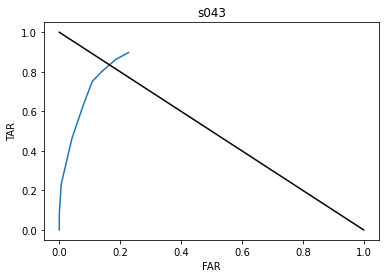

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 8, 65, 149, 219, 251, 266, 278, 286, 302], 'TR': [350, 350, 342, 285, 201, 131, 99, 84, 72, 64, 48], 'FA': [0, 0, 0, 15, 294, 850, 1461, 2134, 2886, 3757, 5012], 'FR': [20000, 20000, 20000, 19985, 19706, 19150, 18539, 17866, 17114, 16243, 14988]}
total cm:  {'TA': [0, 4, 731, 3415, 6172, 8194, 9503, 10389, 11031, 11561, 11926], 'TR': [13300, 13296, 12569, 9885, 7128, 5106, 3797, 2911, 2269, 1739, 1374], 'FA': [0, 0, 1453, 18382, 63594, 137284, 212833, 282247, 343638, 396313, 442702], 'FR': [760000, 760000, 758547, 741618, 696406, 622716, 547167, 477753, 416362, 363687, 317298]}


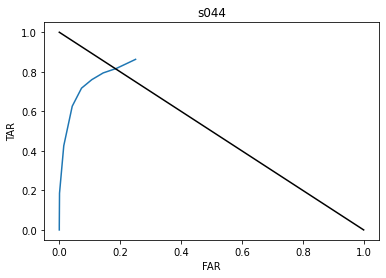

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 52, 190, 282, 319, 336, 343, 344, 345, 346], 'TR': [350, 350, 298, 160, 68, 31, 14, 7, 6, 5, 4], 'FA': [0, 0, 138, 2413, 6793, 10576, 13398, 15576, 17047, 18071, 18636], 'FR': [20000, 20000, 19862, 17587, 13207, 9424, 6602, 4424, 2953, 1929, 1364]}
total cm:  {'TA': [0, 4, 739, 3480, 6321, 8413, 9754, 10655, 11309, 11847, 12228], 'TR': [13650, 13646, 12911, 10170, 7329, 5237, 3896, 2995, 2341, 1803, 1422], 'FA': [0, 0, 1453, 18397, 63888, 138134, 214294, 284381, 346524, 400070, 447714], 'FR': [780000, 780000, 778547, 761603, 716112, 641866, 565706, 495619, 433476, 379930, 332286]}


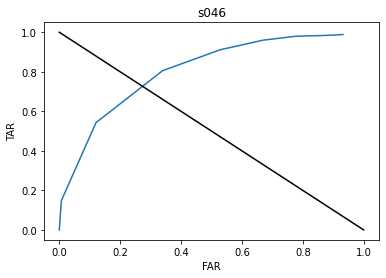

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 9, 73, 159, 238, 278, 299, 317, 321, 327], 'TR': [350, 350, 341, 277, 191, 112, 72, 51, 33, 29, 23], 'FA': [0, 0, 1, 130, 2324, 7912, 12077, 14562, 16216, 17238, 17972], 'FR': [20000, 20000, 19999, 19870, 17676, 12088, 7923, 5438, 3784, 2762, 2028]}
total cm:  {'TA': [0, 4, 791, 3670, 6603, 8732, 10090, 10998, 11653, 12192, 12574], 'TR': [14000, 13996, 13209, 10330, 7397, 5268, 3910, 3002, 2347, 1808, 1426], 'FA': [0, 0, 1591, 20810, 70681, 148710, 227692, 299957, 363571, 418141, 466350], 'FR': [800000, 800000, 798409, 779190, 729319, 651290, 572308, 500043, 436429, 381859, 333650]}


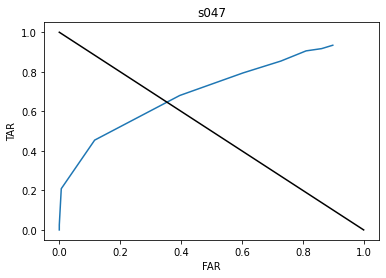

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 16, 121, 235, 288, 308, 320, 326, 330, 333], 'TR': [350, 350, 334, 229, 115, 62, 42, 30, 24, 20, 17], 'FA': [0, 0, 30, 594, 2189, 4745, 7610, 10248, 12215, 13599, 14546], 'FR': [20000, 20000, 19970, 19406, 17811, 15255, 12390, 9752, 7785, 6401, 5454]}
total cm:  {'TA': [0, 4, 800, 3743, 6762, 8970, 10368, 11297, 11970, 12513, 12901], 'TR': [14350, 14346, 13550, 10607, 7588, 5380, 3982, 3053, 2380, 1837, 1449], 'FA': [0, 0, 1592, 20940, 73005, 156622, 239769, 314519, 379787, 435379, 484322], 'FR': [820000, 820000, 818408, 799060, 746995, 663378, 580231, 505481, 440213, 384621, 335678]}


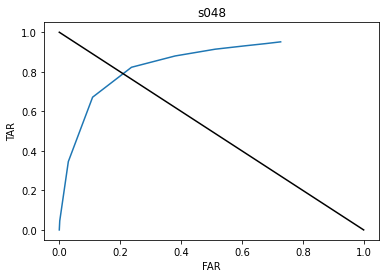

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 2, 26, 218, 286, 313, 324, 329, 335, 338], 'TR': [350, 350, 348, 324, 132, 64, 37, 26, 21, 15, 12], 'FA': [0, 0, 0, 13, 267, 787, 2262, 4978, 7968, 10905, 13528], 'FR': [20000, 20000, 20000, 19987, 19733, 19213, 17738, 15022, 12032, 9095, 6472]}
total cm:  {'TA': [0, 4, 816, 3864, 6997, 9258, 10676, 11617, 12296, 12843, 13234], 'TR': [14700, 14696, 13884, 10836, 7703, 5442, 4024, 3083, 2404, 1857, 1466], 'FA': [0, 0, 1622, 21534, 75194, 161367, 247379, 324767, 392002, 448978, 498868], 'FR': [840000, 840000, 838378, 818466, 764806, 678633, 592621, 515233, 447998, 391022, 341132]}


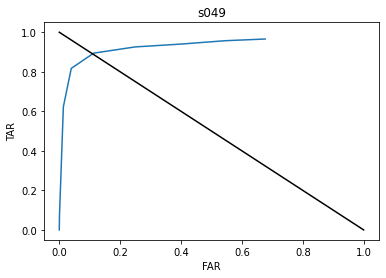

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 27, 105, 183, 227, 255, 277, 290, 302, 311], 'TR': [350, 350, 323, 245, 167, 123, 95, 73, 60, 48, 39], 'FA': [0, 0, 0, 85, 669, 2458, 5007, 6699, 8005, 9260, 10442], 'FR': [20000, 20000, 20000, 19915, 19331, 17542, 14993, 13301, 11995, 10740, 9558]}
total cm:  {'TA': [0, 4, 818, 3890, 7215, 9544, 10989, 11941, 12625, 13178, 13572], 'TR': [15050, 15046, 14232, 11160, 7835, 5506, 4061, 3109, 2425, 1872, 1478], 'FA': [0, 0, 1622, 21547, 75461, 162154, 249641, 329745, 399970, 459883, 512396], 'FR': [860000, 860000, 858378, 838453, 784539, 697846, 610359, 530255, 460030, 400117, 347604]}


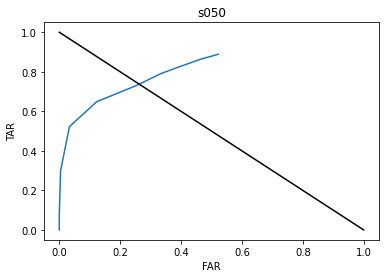

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 1, 18, 99, 176, 235, 278, 302, 324, 329], 'TR': [350, 350, 349, 332, 251, 174, 115, 72, 48, 26, 21], 'FA': [0, 0, 1, 110, 702, 2370, 4546, 6854, 8876, 10502, 11970], 'FR': [20000, 20000, 19999, 19890, 19298, 17630, 15454, 13146, 11124, 9498, 8030]}
total cm:  {'TA': [0, 4, 845, 3995, 7398, 9771, 11244, 12218, 12915, 13480, 13883], 'TR': [15400, 15396, 14555, 11405, 8002, 5629, 4156, 3182, 2485, 1920, 1517], 'FA': [0, 0, 1622, 21632, 76130, 164612, 254648, 336444, 407975, 469143, 522838], 'FR': [880000, 880000, 878378, 858368, 803870, 715388, 625352, 543556, 472025, 410857, 357162]}


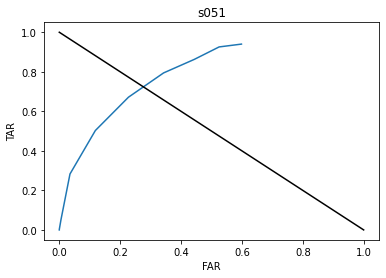

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 2, 24, 68, 109, 151, 212, 264, 310, 322, 324], 'TR': [350, 348, 326, 282, 241, 199, 138, 86, 40, 28, 26], 'FA': [0, 0, 0, 0, 18, 364, 1330, 2897, 4297, 5157, 5919], 'FR': [20000, 20000, 20000, 20000, 19982, 19636, 18670, 17103, 15703, 14843, 14081]}
total cm:  {'TA': [0, 4, 846, 4013, 7497, 9947, 11479, 12496, 13217, 13804, 14212], 'TR': [15750, 15746, 14904, 11737, 8253, 5803, 4271, 3254, 2533, 1946, 1538], 'FA': [0, 0, 1623, 21742, 76832, 166982, 259194, 343298, 416851, 479645, 534808], 'FR': [900000, 900000, 898377, 878258, 823168, 733018, 640806, 556702, 483149, 420355, 365192]}


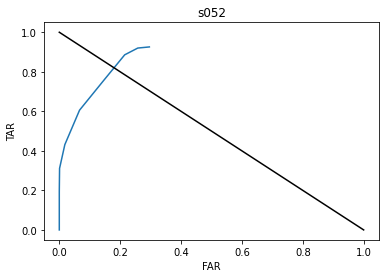

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 15, 90, 191, 262, 298, 315, 325, 329, 330], 'TR': [350, 350, 335, 260, 159, 88, 52, 35, 25, 21, 20], 'FA': [0, 0, 0, 31, 426, 973, 1417, 1923, 2409, 2847, 3285], 'FR': [20000, 20000, 20000, 19969, 19574, 19027, 18583, 18077, 17591, 17153, 16715]}
total cm:  {'TA': [0, 6, 870, 4081, 7606, 10098, 11691, 12760, 13527, 14126, 14536], 'TR': [16100, 16094, 15230, 12019, 8494, 6002, 4409, 3340, 2573, 1974, 1564], 'FA': [0, 0, 1623, 21742, 76850, 167346, 260524, 346195, 421148, 484802, 540727], 'FR': [920000, 920000, 918377, 898258, 843150, 752654, 659476, 573805, 498852, 435198, 379273]}


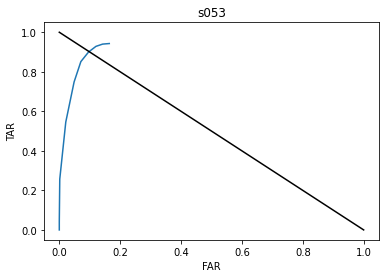

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 21, 63, 82, 93, 96, 99, 101, 112, 146], 'TR': [350, 350, 329, 287, 268, 257, 254, 251, 249, 238, 204], 'FA': [0, 0, 2, 160, 849, 2388, 4326, 6023, 7512, 8892, 10502], 'FR': [20000, 20000, 19998, 19840, 19151, 17612, 15674, 13977, 12488, 11108, 9498]}
total cm:  {'TA': [0, 6, 885, 4171, 7797, 10360, 11989, 13075, 13852, 14455, 14866], 'TR': [16450, 16444, 15565, 12279, 8653, 6090, 4461, 3375, 2598, 1995, 1584], 'FA': [0, 0, 1623, 21773, 77276, 168319, 261941, 348118, 423557, 487649, 544012], 'FR': [940000, 940000, 938377, 918227, 862724, 771681, 678059, 591882, 516443, 452351, 395988]}


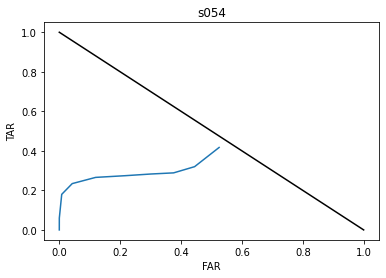

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 13, 55, 129, 195, 250, 285, 307, 320, 329], 'TR': [350, 350, 337, 295, 221, 155, 100, 65, 43, 30, 21], 'FA': [0, 0, 0, 15, 163, 678, 1769, 3153, 4697, 6481, 8677], 'FR': [20000, 20000, 20000, 19985, 19837, 19322, 18231, 16847, 15303, 13519, 11323]}
total cm:  {'TA': [0, 6, 906, 4234, 7879, 10453, 12085, 13174, 13953, 14567, 15012], 'TR': [16800, 16794, 15894, 12566, 8921, 6347, 4715, 3626, 2847, 2233, 1788], 'FA': [0, 0, 1625, 21933, 78125, 170707, 266267, 354141, 431069, 496541, 554514], 'FR': [960000, 960000, 958375, 938067, 881875, 789293, 693733, 605859, 528931, 463459, 405486]}


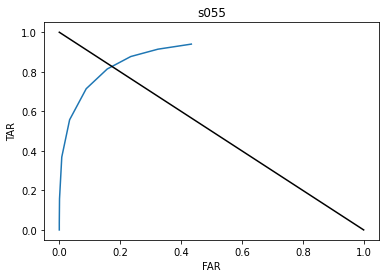

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 28, 167, 258, 292, 308, 314, 324, 332, 336], 'TR': [350, 350, 322, 183, 92, 58, 42, 36, 26, 18, 14], 'FA': [0, 0, 70, 1122, 3928, 7558, 10635, 12658, 13854, 14744, 15477], 'FR': [20000, 20000, 19930, 18878, 16072, 12442, 9365, 7342, 6146, 5256, 4523]}
total cm:  {'TA': [0, 6, 919, 4289, 8008, 10648, 12335, 13459, 14260, 14887, 15341], 'TR': [17150, 17144, 16231, 12861, 9142, 6502, 4815, 3691, 2890, 2263, 1809], 'FA': [0, 0, 1625, 21948, 78288, 171385, 268036, 357294, 435766, 503022, 563191], 'FR': [980000, 980000, 978375, 958052, 901712, 808615, 711964, 622706, 544234, 476978, 416809]}


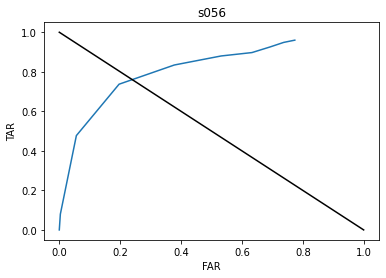

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
user cm:  {'TA': [0, 0, 49, 177, 247, 292, 318, 328, 336, 342, 345], 'TR': [350, 350, 301, 173, 103, 58, 32, 22, 14, 8, 5], 'FA': [0, 0, 339, 2988, 6380, 9242, 11554, 13408, 14958, 16197, 17120], 'FR': [20000, 20000, 19661, 17012, 13620, 10758, 8446, 6592, 5042, 3803, 2880]}
total cm:  {'TA': [0, 6, 947, 4456, 8266, 10940, 12643, 13773, 14584, 15219, 15677], 'TR': [17500, 17494, 16553, 13044, 9234, 6560, 4857, 3727, 2916, 2281, 1823], 'FA': [0, 0, 1695, 23070, 82216, 178943, 278671, 369952, 449620, 517766, 578668], 'FR': [1000000, 1000000, 998305, 976930, 917784, 821057, 721329, 630048, 550380, 482234, 421332]}


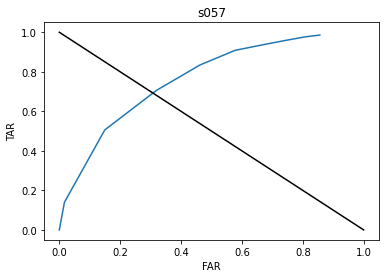

In [ ]:

bounds = np.linspace(0, 10, 11) # return evenly spaced numbers over a specified interval, so 10 evenly spaced samples from 0 to 10
  # array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
  #         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

total_cm = {}

for user_i in range(0,len(individuals)):
  confusion_matrix_progression_probability = test_probability_trained_bound(data, individuals[user_i], bounds, 10, 50, 0) 
  # plt.plot(np.array(confusion_matrix_progression_probability['FA']) / (confusion_matrix_progression_probability['FA'][0] + confusion_matrix_progression_probability['FR'][0]))
  # plt.plot(np.array(confusion_matrix_progression_probability['TA']) / (confusion_matrix_progression_probability['TA'][0] + confusion_matrix_progression_probability['TR'][0]))
  # plt.show()

  print('user cm: ', confusion_matrix_progression_probability)
  print('total cm: ', total_cm)
  if len(total_cm) == 0:
    total_cm = confusion_matrix_progression_probability
  else:
    for rate in confusion_matrix_progression_probability:
      added_prob = list(map(add, total_cm[rate], confusion_matrix_progression_probability[rate]))
      total_cm[rate] = added_prob

    # 'steeper' slop -> FA < TA, and we want to optimize this
    plt.plot(np.array(confusion_matrix_progression_probability['FA']) / (confusion_matrix_progression_probability['FA'][0] + confusion_matrix_progression_probability['FR'][0]), np.array(confusion_matrix_progression_probability['TA']) / (confusion_matrix_progression_probability['TA'][0] + confusion_matrix_progression_probability['TR'][0]))
    plt.plot(np.linspace(0, 1, 2), np.linspace(1, 0, 2), color = "black")
    plt.xlabel("FAR")
    plt.ylabel("TAR")
    plt.title(individuals[user_i])
    plt.show()



avg cm:  {'TA': [0.0, 0.11764705882352941, 19.529411764705884, 90.84313725490196, 166.92156862745097, 220.23529411764707, 254.13725490196077, 276.4901960784314, 292.54901960784315, 305.11764705882354, 314.15686274509807], 'TR': [350.0, 349.88235294117646, 330.47058823529414, 259.15686274509807, 183.07843137254903, 129.76470588235293, 95.86274509803921, 73.50980392156863, 57.450980392156865, 44.88235294117647, 35.84313725490196], 'FA': [0.0, 0.0, 39.88235294117647, 510.94117647058823, 1737.1764705882354, 3689.901960784314, 5690.686274509804, 7516.862745098039, 9109.372549019608, 10469.862745098038, 11682.117647058823], 'FR': [20000.0, 20000.0, 19960.117647058825, 19489.058823529413, 18262.823529411766, 16310.098039215687, 14309.313725490196, 12483.137254901962, 10890.627450980392, 9530.137254901962, 8317.882352941177]}


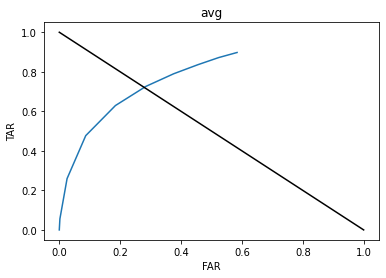

6
6.0


In [ ]:
avg_cm = {}

for rate in total_cm:
  avg_prob = list(map(lambda x: x/len(individuals), total_cm[rate]))
  avg_cm[rate] = avg_prob
print('avg cm: ', avg_cm)

plt.plot(np.array(avg_cm['FA']) / (avg_cm['FA'][0] + avg_cm['FR'][0]),
        np.array(avg_cm['TA']) / (avg_cm['TA'][0] + avg_cm['TR'][0]))
plt.plot(np.linspace(0, 1, 2), np.linspace(1, 0, 2), color = "black")
plt.title("avg")
plt.xlabel("FAR")
plt.ylabel("TAR")
plt.show()


TAR_progression = np.array(avg_cm['TA']) / (avg_cm['TA'][0] + avg_cm['TR'][0])
FAR_progression = np.array(avg_cm['FA']) / (avg_cm['FA'][0] + avg_cm['FR'][0])

best_index = np.argmin(abs(1 - (TAR_progression + FAR_progression)))
best_bound = bounds[best_index]
print(best_index)
print(best_bound)

#the best bound from the large data set is = 6.0

# Putting it together


In [ ]:
#import Survey A Data

survey_data = pd.read_csv("/content/drive/Shared drives/Usable Passwords COMPS/SurveyData/Survey_A.csv")

#session 1 = first 10 inputs (training 10)

#get_random_samples(survey_data, "s002", 1, 10)

#the best bound from the large data set is = 6.0
#bounds = 6
#does the user fall within the bounds? Pass or Fail

In [ ]:
def get_probability_trained_bound_survey(df, user, session=1):
  '''
  Extract useful data, and compute the mean and variance the 10 first reps. 
  
  '''
  usable_rows = (df["subject"] == user) & (df["sessionIndex"] == session) # filter 1 user, 1 session
  df = df[usable_rows] # usable = chosen user and session
  
  global random_seed 
 
  #pandas: return a random sample, where frac = fraction of axis items to return
  #df = df.sample(frac=1, random_state = random_seed) 

  df.reset_index(inplace=True, drop=True) # resets index 
  df = df[df.columns[3:]] # remove subject, sessionIndex, rep

  average_row = {}
  stdv = {}
  for i in df.columns:
    average_row[i] = df[i].mean()
    stdv[i] = df[i].std()
  df = df.append(average_row, ignore_index=True)
  df = df.append(stdv, ignore_index=True)

  probability_trained_bound = df.loc[10:] # mean, stdev
  probability_trained_bound = probability_trained_bound.rename(index={10:"avg", 11:"stdv"})
  return probability_trained_bound

In [ ]:
individuals = survey_data["subject"].unique() # NumPy: returns the sorted unique elements

In [ ]:
get_probability_trained_bound_survey(survey_data, user = "02tnxibyzlsiq0jmrji2buf", session = 1)

,H.period,UD.period.t,H.t,UD.t.i,H.i,UD.i.e,H.e,UD.e.five,H.five,UD.five.Shift.r,H.Shift.r,UD.Shift.r.o,H.o,UD.o.a,H.a,UD.a.n,H.n,UD.n.l,H.l
avg,0.123700,0.265700,0.112500,0.002200,0.149800,-0.046400,0.137500,0.563500,0.107600,0.45670,0.113900,0.077800,0.147100,0.0249,0.135200,0.034200,0.133600,0.023000,0.142200
stdv,0.042484,0.202297,0.016575,0.028225,0.023696,0.046798,0.037188,0.344629,0.011946,0.23531,0.032491,0.059447,0.016231,0.0526,0.017912,0.100554,0.024487,0.138294,0.042591


In [ ]:
def test_probability_trained_bound_survey(df, user, bound, session_train = 2):
  
  confusion_matrix = {"TA":0, "TR":0, "FA":0, "FR":0}
  # np.random.seed(0) 
  training_session = 1 # np.random.randint(1, 9) aha
  avg_stdv = get_probability_trained_bound_survey(df, user, session = session_train)
  #       H.period  UD.period.t       H.t  ...       H.n    UD.n.l       H.l
  # avg   0.105270     0.119000  0.082580  ...  0.080550  0.214490  0.100510
  # stdv  0.015819     0.117596  0.009139  ...  0.007815  0.146463  0.014378

  # limit calculations
  max_limit = avg_stdv.loc["avg"] + bound * avg_stdv.loc["stdv"]
  min_limit = avg_stdv.loc["avg"] - bound * avg_stdv.loc["stdv"]

  # 1) TRUE: test 9 sessions data against mean/ stdev calculations
  # we are trying to identify a 'user' (testing for one user's sessions)
    
  usable_rows = (df["subject"] == user) & (df["sessionIndex"] == 3) # filter 1 user, 1 session
  test_sample = df[usable_rows] # usable = chosen user and session
  test_sample.reset_index(inplace = True)
  confusion_matrix = update_confusion_matrix(confusion_matrix, min_limit, max_limit, test_sample, "T", 0)


  usable_rows = (df["subject"] != user) 
  test_sample = df[usable_rows] # usable = chosen user and session
  test_sample.reset_index(inplace = True)
  confusion_matrix = update_confusion_matrix(confusion_matrix, min_limit, max_limit, test_sample, "F", 0)
  return confusion_matrix


In [ ]:
def update_confusion_matrix(confusion_matrix, min_limit, max_limit, samples, true_user, acceptable_num_digraphs_out_of_bounds = 0):
  for i in samples.index:
    if (sum((samples.loc[i] - min_limit) < 0) > acceptable_num_digraphs_out_of_bounds) or (sum((max_limit - samples.loc[i]) < 0) > acceptable_num_digraphs_out_of_bounds):
      confusion_matrix[true_user+"R"] = confusion_matrix[true_user+"R"] + 1
    else:
      confusion_matrix[true_user+"A"] = confusion_matrix[true_user+"A"] + 1
  return confusion_matrix

In [ ]:
test_probability_trained_bound_survey(survey_data, user ="02tnxibyzlsiq0jmrji2buf", bound=6, session_train = 2)

{'FA': 275, 'FR': 1080, 'TA': 9, 'TR': 1}

In [ ]:
TAR_list = []
FAR_list = []
for users in survey_data["subject"].unique():
  #check if user has 30 inputs
  if(survey_data["subject"]==users).sum() != 30:
    continue
  confusion_matrix = test_probability_trained_bound_survey(survey_data, user = users, bound=6, session_train = 2)
  TAR = confusion_matrix['TA']/(confusion_matrix['TA'] + confusion_matrix['TR'])
  FAR = confusion_matrix['FA']/(confusion_matrix['FA'] + confusion_matrix['FR'])
  TAR_list.append(TAR)
  FAR_list.append(FAR)


In [ ]:
print(np.array(TAR_list).mean())
print(np.array(FAR_list).mean())
print(np.array(TAR_list).min())
print(np.array(FAR_list).max())

0.8088888888888889
0.2105945059450594
0.4
0.8590405904059041
